In [1]:
from hamilton_ice.pipeline import get_func_args, object_io_nodes, build_pipeline
from hamilton_ice.io.artifact import artifact
from hamilton_ice.io.pandas import pandas_csv_source, pandas_msgpack
from hamilton_ice.io.dummy import dummy
from hamilton_ice.util.graphviz import dag_plot
import pandas as pd
import numpy as np
import random
import torch
from dataclasses import dataclass
from hamilton_ice.util.graphviz import dag_plot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Questions
* Use overrides instead of partial results
* Feature engineering is shared through module
* How to seperate code into docker containers for pyspark and pytorch
    * @config.when
    * module separation
    * all in one
* Rerun the dag for each epoch

# Misc DataClass Code
These are used to describe shapes for more complex composite datastructures that contain config, combinations of training/validation data, or loss metrics.

In [2]:
# We maintain a small holdout set of data for validation purposes.
# I was pretty sloppy with this, it's not randomized properly, and it's 
# small and very noisy. I had a much better version of this that I can recreate later.
validation = None

# This is a singular config object that's 
# used for any free parameter we wish to control 
# within the training/serving pipeline.  In prod it could be sealed.
@dataclass
class Config:
    observed_size = 0
    reservoir_size = 50
    random_seed = 42
    output_field = "Survived"

# Since everything is streaming in this approach, we can generate both training and validation
# minibatches on the fly.  This dataclass clearly specifies them both as they are chunked
# out of the data.
@dataclass
class TrainingValidationMinibatch:
    train : pd.DataFrame
    validation : pd.DataFrame
        
# Ditto for metrics on the minibatch metrics
@dataclass
class AnnotatedLoss:
    loss : float
    validation_loss : float


In [3]:
# Simple Titanic
# This is a simple class interface that generates raw minibatches from a source.
# The source function just needs to return a url/file location to pull chunked CSV records from.
class Titanic:
    @artifact
    def params():
        return {}
    
    @artifact
    def config():
        return Config()
    
    @pandas_csv_source
    def minibatch(config):
        return "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"    

# We can build the pipeline so that we can use the generators
build_pipeline(Titanic)        

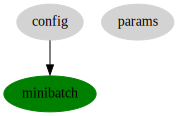

In [4]:
# Not much to see here on the DAG plot.  We pass config into minibatch. 
# There's an extra params node that's not used but required by the code.
# I was too lazy to remove it here, just ignore it.
dag_plot(Titanic)

In [5]:
# Let's look at a sample of the raw data from the generator, it's a pandas dataframe.
next(Titanic.minibatch.generator()).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# We can continue to build on the Titanic DAG.
# This time by adding functions useful for normalization.
class TitanicNormalized(Titanic):       
    @dummy
    def normalized_data(minibatch, config):
        dat = minibatch
        normalized = pd.DataFrame({
            "Survived" : dat["Survived"].astype(float),
            "NormPclass" : dat["Pclass"]/3,
            "MaleSex" : (dat["Sex"] == "male").astype(float),
            "FemaleSex" : (dat["Sex"] == "female").astype(float),
            "NormAge" : dat["Age"] / 100,
            "NormSibSp" :dat["SibSp"] /10,
            "NormParch" : dat["Parch"]/10,
            "NormFare" : dat["Fare"]/1000,
            "Embarked_C" : (dat["Embarked"] == "C").astype(float),
            "Embarked_S" : (dat["Embarked"] == "S").astype(float),
            "Embarked_Q" : (dat["Embarked"] == "Q").astype(float),
        })
        mean_value = normalized["NormAge"].mean(skipna=True)
        normalized["NormAge"].fillna(mean_value, inplace=True)
        yield normalized
    
    @dummy
    def annotated_data(normalized_data, config):
        np.random.seed(config.random_seed)
        msk = np.random.rand(len(normalized_data)) < 0.8
        normalized_data["train"] = msk
        normalized_data["eval"] = ~msk
        yield normalized_data

build_pipeline(TitanicNormalized)  

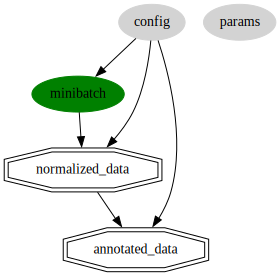

In [7]:
dag_plot(TitanicNormalized)

In [13]:
# Here's the normalized step. All the values are between 0 and 1 here.  
# (We can do better norms I know)
next(TitanicNormalized.normalized_data.generator()).head()

,Survived,NormPclass,MaleSex,FemaleSex,NormAge,NormSibSp,NormParch,NormFare,Embarked_C,Embarked_S,Embarked_Q
0,0.0,1.000000,1.0,0.0,0.22,0.1,0.0,0.007250,0.0,1.0,0.0
1,1.0,0.333333,0.0,1.0,0.38,0.1,0.0,0.071283,1.0,0.0,0.0
2,1.0,1.000000,0.0,1.0,0.26,0.0,0.0,0.007925,0.0,1.0,0.0
3,1.0,0.333333,0.0,1.0,0.35,0.1,0.0,0.053100,0.0,1.0,0.0
4,0.0,1.000000,1.0,0.0,0.35,0.0,0.0,0.008050,0.0,1.0,0.0


In [22]:
# Here we are adding "train" and "eval" flags for each record in the chunked iterator.
# Note that we lock the random seed to ensure these are the same each run.
next(TitanicNormalized.annotated_data.generator()).head().iloc[:,-5:]

,Embarked_C,Embarked_S,Embarked_Q,train,eval
0,0.0,1.0,0.0,True,False
1,1.0,0.0,0.0,False,True
2,0.0,1.0,0.0,True,False
3,0.0,1.0,0.0,True,False
4,0.0,1.0,0.0,True,False


In [24]:
# This DAG adds in annotated training phase that generates training and validation minibatches
class TitanicAnnotated(TitanicNormalized):        
    @dummy    
    def evaluate(annotated_data):  
        yield annotated_data[annotated_data["eval"]]
    
    
    @dummy                                 
    def annotated_train(annotated_data, config):
        train = annotated_data[annotated_data["train"]].drop(["train", "eval"], axis = 1).copy()
        
        global validation
        
        k = random.randint(0, config.reservoir_size)
        if validation is None:
            validation = train.copy()
        else:
            # swap an element with reservoir
            val_idx = random.choice(validation.index)
            train_idx = random.choice(train.index)
            validation.loc[val_idx] = train.loc[train_idx]

        yield TrainingValidationMinibatch(train=train, validation=validation)
        
build_pipeline(TitanicAnnotated)

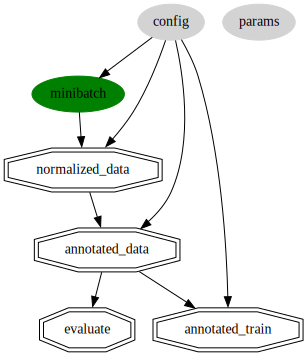

In [25]:
dag_plot(TitanicAnnotated)

In [35]:
# Here we are peeking into the train/validation minibatches. 
# Initially the validation minibatch will look identical, but later on it will contain samples
# across the epoch.

tv = next(TitanicAnnotated.annotated_train.generator())
print("TRAIN:\n")
print(tv.train.head())
print("\nVALIDATE:\n")
print(tv.validation.head())

TRAIN:

   Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch  \
0       0.0    1.000000      1.0        0.0   0.2200        0.1        0.0   
2       1.0    1.000000      0.0        1.0   0.2600        0.0        0.0   
3       1.0    0.333333      0.0        1.0   0.3500        0.1        0.0   
4       0.0    1.000000      1.0        0.0   0.3500        0.0        0.0   
5       0.0    1.000000      1.0        0.0   0.2772        0.0        0.0   

   NormFare  Embarked_C  Embarked_S  Embarked_Q  
0  0.007250         0.0         1.0         0.0  
2  0.007925         0.0         1.0         0.0  
3  0.053100         0.0         1.0         0.0  
4  0.008050         0.0         1.0         0.0  
5  0.008458         0.0         0.0         1.0  

VALIDATE:

   Survived  NormPclass  MaleSex  FemaleSex  NormAge  NormSibSp  NormParch  \
0       0.0    1.000000      1.0        0.0   0.2200        0.1        0.0   
2       1.0    1.000000      0.0        1.0   0.2600   

In [38]:
# This DAG will contain the config for the model, and use the upstream annotated 
# minibatches for trainining the model.

class TitanicTrain(TitanicAnnotated):
    @artifact
    def optimizer(model):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
        return optimizer
    
    @artifact
    def criterion(config):
        return torch.nn.BCELoss() 
    
    @dummy
    def train(annotated_train, model, optimizer, criterion):
        optimizer.zero_grad()
        train = annotated_train.train.drop(["Survived"], 1).to_numpy()
        train_features = torch.tensor(train)
        train_outputs = model(train_features.float())
        train_labels = torch.tensor(annotated_train.train["Survived"].to_numpy())

        validation = annotated_train.validation.drop(["Survived"], 1).to_numpy()
        validation_features = torch.tensor(validation)
        validation_outputs = model(validation_features.float())
        validation_labels = torch.tensor(annotated_train.validation["Survived"].to_numpy())
        loss = criterion(
            train_outputs.flatten().float(), 
            train_labels.flatten().float()
            )

        validation_loss = criterion(
            validation_outputs.flatten().float(), 
            validation_labels.flatten().float()
            )

        loss.backward() 
        optimizer.step()
      
        yield AnnotatedLoss(loss = loss.item(), validation_loss = validation_loss.item())
    
    @artifact
    def model (config, annotated_train):
        n_features = annotated_train.train.drop(["Survived"], 1).shape[1]
        model = torch.nn.Sequential(torch.nn.Linear(n_features, 50),
                            torch.nn.ReLU(),
                            torch.nn.Linear(50, 1),
                            torch.nn.Sigmoid())
        return model
        
build_pipeline(TitanicTrain)

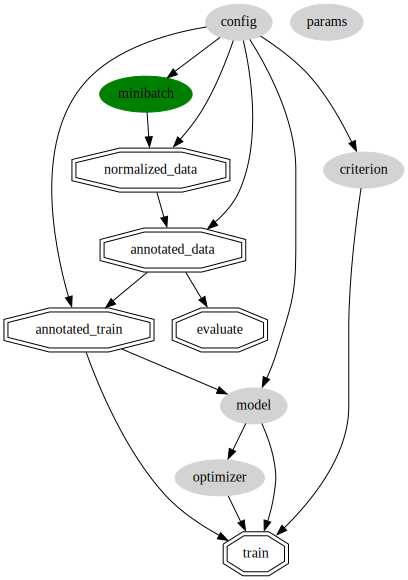

In [39]:
dag_plot(TitanicTrain)

In [40]:
# Here's a dead simple training loop.  
# This easily be abstracted away with an additional feature/service, but it's
# easy enough to follow along here.
epochs = []
for epoch in range(0,200):
    if epoch % 100 == 0:
        print(f"epoch: {epoch}")
    epoch = []
    for aloss in TitanicTrain.train.generator():
        epoch.append(aloss.__dict__)
    epoch = pd.DataFrame.from_records(epoch)
    epochs.append(epoch.mean())

epoch: 0
epoch: 100


<Axes: >

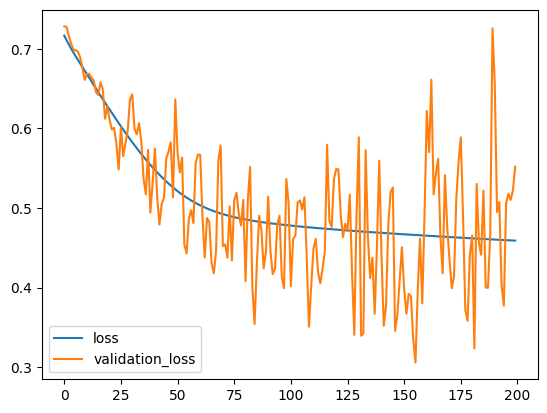

In [42]:
# Let's take a look at our loss (which should be smooth), against our noisy/small validation set.
pd.concat(epochs,1).transpose().plot()

In [44]:
# We can access the trained model by calling its artifact method. 
model = TitanicTrain.model.artifact()
model

Sequential(
  (0): Linear(in_features=10, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
  (3): Sigmoid()
)